In [ ]:
Skopiować kod Transformera z torchvision.
Podpiąć nn.Linear po każdej warstwie i je trenować. Patrzeć na accuracy po każdej warstwie
Nie przekazywać danych z tych warstw liniowych dalej do modelu, a jedynie zebrać info o accuracy.

In [ ]:
Zrobić eksperymenty: 
1) Na jedna epokę odfreezować wszystkie parametry i douczać cały model + głowy.
2) Odfreezowane tylko classification heady (warstwy liniowe) i uczenie ich

Być może trzeba dopasować inny 'lr' dla optimizer2 - uczenia uprzednio zamrożonych wag. Augmentacja obrazów wejściowych - poszukać w artykułach, jakie propojnują + zaczerpnąć podstawową implementacje
papers with codes

weight decay, mniejszy learning rate dla 150 elem.

In [ ]:
import torch
import time
import os
import torch.nn as nn
from torchvision.datasets import FakeData, Flowers102
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Compose, Lambda, Resize
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16, ViT_B_16_Weights
from sklearn.model_selection import ParameterGrid
from collections.abc import Iterable
from sklearn.utils import shuffle
from torch.utils.data import random_split

In [ ]:
torch.cuda.empty_cache()

  0%|          | 0/344862509 [00:00<?, ?it/s]

Extracting flowers-102/102flowers.tgz to flowers-102


  0%|          | 0/502 [00:00<?, ?it/s]

  0%|          | 0/14989 [00:00<?, ?it/s]

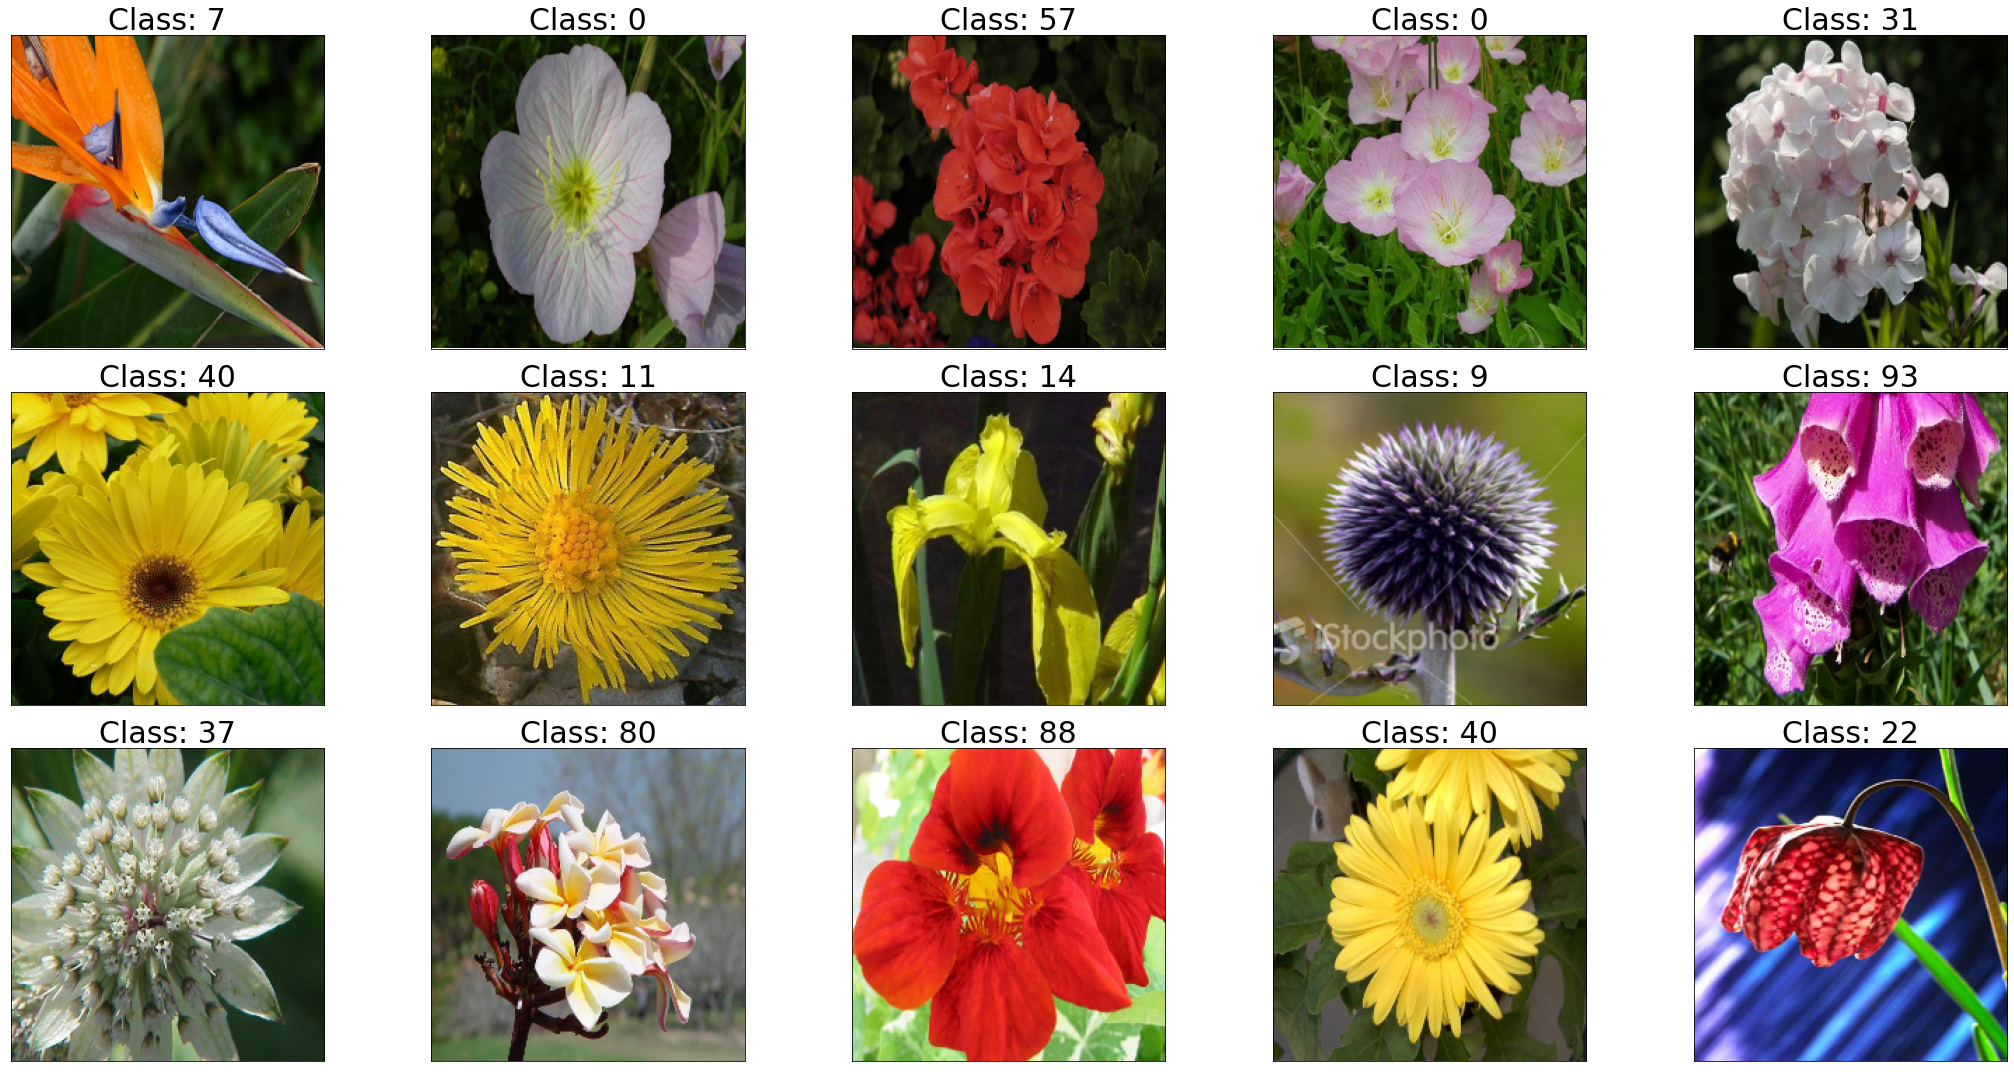

In [ ]:
transforms = Compose([ToTensor(), Resize([224, 224])])
dataset = Flowers102(root=".", split="train", transform=transforms, download=True)

# print(dataset[0])
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# x, y = next(iter(loader))

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"Class: {y[ind]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from collections import Counter

def check_labels(dataset):
    check = Counter([str(label) for _, label in dataset])
    all_labels = all([False if str(i) not in check.keys() else True for i in range(0, 102)])
    if all_labels:
      print("There's at leas 1 instance of each class")
    else:
      print("At least one class is not represented in this set")

In [ ]:
weights = ViT_B_16_Weights.IMAGENET1K_V1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = vit_b_16(progress=True, weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
def save_model(model, dir: str, model_name: str) -> None:
    """Saves a model to a given directory - useful for training models with freezed and unfreezed params"""
    curr_dir = os.getcwd()
    path = f"/{dir}/"
    path_to_model = path + f"{model_name}.pt"
    exists = os.path.exists(path)

    if not exists:
      # Create a new directory because it does not exist 
        os.makedirs(path)

    # Save the model in a given directory
    torch.save(model.state_dict(), model_name)# path_to_model)

In [ ]:
save_model(model, "models", "/models/new_model.pt")

In [ ]:
weights = ViT_B_16_Weights.IMAGENET1K_V1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
preprocess = weights.transforms()
transform = Compose([ToTensor(), Lambda(lambda x: preprocess(x))])

train_dataset = Flowers102(root='.', 
                        split='train',
                        download=True,
                        transform=transform)

test_dataset = Flowers102(root='.', 
                       split='test',
                       download=True,
                       transform=transform)

n_train = int(0.8*len(train_dataset))
n_valid = len(train_dataset) - n_train

train_dataset, valid_dataset = random_split(train_dataset, (n_train, n_valid))
print(len(train_dataset), len(valid_dataset), len(test_dataset))

# check_labels(train_dataset)
# check_labels(valid_dataset)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

816 204 6149


In [ ]:
def plot_img(img, preprocess, title=None):
  img = np.transpose(img.numpy(), (1, 2, 0))
  mean = np.array(preprocess.mean)
  std = np.array(preprocess.std)

  img = std*img + mean
  img = np.clip(img, 0, 1)
  plt.imshow(img)
  if title is not None:
      plt.title(f"Class: {int(title)}")
  # plt.pause(0.001)

torch.Size([32, 3, 224, 224]) torch.Size([32])


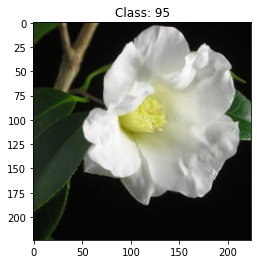

In [ ]:
batch, labels = next(iter(train_loader))
print(batch.shape, labels.shape)
plot_img(img=batch[0], preprocess=preprocess, title=labels[0])

In [ ]:
class BasicViT(nn.Module):

    def __init__(self, *args, **kwargs):
      super().__init__()
      self.vit = self.with_freezed_params(vit_b_16(weights =  ViT_B_16_Weights.IMAGENET1K_V1))
      self.vit.heads = nn.Linear(in_features=768, out_features=kwargs.get('out_heads', 102), bias=True)

    def forward(self, x):
        return self.vit(x)

    def with_freezed_params(self, model):
        for param in model.parameters():
          param.requires_grad = False
        return model
        

In [ ]:
# print(len([p for p in model.parameters() if p.requires_grad]))
# N = 152

def unfreeze_params(model, unfreeze_params=False, all=False):
    if unfreeze_params and all:
        for param in model.parameters():
            param.requires_grad = True

    else:
        N = len([p for p in model.parameters()])
        for idx, param in enumerate(model.parameters()):
            if idx == N-2 or idx == N-1:
                param.requires_grad = not unfreeze_params
            else:
                param.requires_grad = unfreeze_params

unfreeze_params(model, True)
print(len([p for p in model.parameters() if p.requires_grad]))
unfreeze_params(model, True, True)
print(len([p for p in model.parameters() if p.requires_grad]))
unfreeze_params(model, False)
print(len([p for p in model.parameters() if p.requires_grad]))

150
152
2


In [ ]:
basic_model = BasicViT()
torch.save(basic_model, "BASIC_MODEL.pt")

In [ ]:
def valid(model, loader):
    model.eval()
    with torch.no_grad():
        # initialize the number of correct predictions
        correct: int = 0 
        N: int = 0

        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            N += y.shape[0]

            # pass through the network
            output: torch.Tensor = model(x)

            # update the number of correctly predicted examples
            correct += sum([torch.argmax(output[k]) == y[k] for k in range(output.shape[0])])

    return correct / N


def run_epoch(model, optimizer, criterion, loader, optimizer2=None):
    """param :unfreezed: train the model during the last epoch with unfreezed all wieghts."""
    model.train()
    N: int = 0
    
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        N += y.shape[0]

        #don't accumulate gradients
        optimizer.zero_grad()
        if optimizer2:
            optimizer2.zero_grad()
        output: torch.Tensor = model(x)

        loss: torch.Tensor = criterion(output, target=y)
        #backwards pass through the network
        loss.backward()

        #apply gradients
        optimizer.step()
        if optimizer2:
            optimizer2.step()


def train_with_params(params, criterion, datasets, unfreezed = False, at_beginning=False):
    train_dataset, valid_dataset, test_dataset = datasets["train"], datasets["valid"], datasets["test"]
    train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=params['batch_size'], shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=params['batch_size'], shuffle=False)

    # test_model = BasicViT().to(device)  # for random weight initialization
    test_model = torch.load("BASIC_MODEL.pt")
    test_model = test_model.to(device)
    # test_model = torch.load("BASIC_MODEL.pt").to(device)

    optimizer = torch.optim.Adam([p for p in test_model.parameters() if p.requires_grad], lr=params['lr'])
    optimizer2 = None

    if unfreezed:
        unfreeze_params(test_model, unfreeze_params=True, all=False)
        print("After switching grads ON: ",len([p for p in test_model.parameters() if p.requires_grad]))
        optimizer2 = torch.optim.Adam([p for p in test_model.parameters() if p.requires_grad], lr=1e-4)
        unfreeze_params(test_model, unfreeze_params=False, all=False)

    for epoch in range(params["epochs_num"]):
        if at_beginning and epoch == 0 and unfreezed:
            print("Training with unfreezed params, first epoch")
            unfreeze_params(test_model, unfreeze_params=True, all=True)
            epoch_train_loss = run_epoch(test_model, optimizer, criterion, train_loader, optimizer2=optimizer2)
            unfreeze_params(test_model, unfreeze_params=False)

        elif not at_beginning and epoch == params["epochs_num"]-1 and unfreezed:
            print("Training with unfreezed params, last epoch")
            unfreeze_params(test_model, unfreeze_params=True, all=True)
            epoch_train_loss = run_epoch(test_model, optimizer, criterion, train_loader, optimizer2=optimizer2)
            # unfreeze_params(test_model, unfreeze_params=False)
        else:
            print(f"Training with freezed params, epoch = {epoch}")
            epoch_train_loss = run_epoch(test_model, optimizer, criterion, train_loader)

    model_valid_acc = valid(test_model, valid_loader)
    # model_test_acc = valid(test_model, test_loader)

    return model_valid_acc, test_model #, model_test_acc


def make_params_grid(param_grid, max_num_sets=None, randomize=True):
    to_list = lambda x: [x] if not isinstance(x, Iterable) else x

    params = {k: to_list(v) for k, v in param_grid.items()}
    if randomize:
        grid = shuffle(ParameterGrid(params))
        return grid[:max_num_sets]

    return ParameterGrid(params)


def find_best_params(param_grid, max_num_sets, criterion, datasets, unfreezed=False, at_beginning=False):
    best_params = {}
    best_valid_acc = 0.0

    param_grid = make_params_grid(param_grid, max_num_sets, randomize=True)

    for i, params in enumerate(param_grid):
        # model_valid_acc, model_test_acc = train_with_params(params, optimizer, criterion, datasets)
        model_valid_acc, trained_model = train_with_params(params, criterion, datasets, unfreezed, at_beginning)
        if max_num_sets > 1:
            print(f'Model: {i} trained, valid accuracy: {model_valid_acc:.4f}')
        else:
            print(f'Model trained, valid accuracy: {model_valid_acc:.4f}')

        if model_valid_acc > best_valid_acc:
            best_valid_acc = model_valid_acc
            best_params = params
            torch.save(trained_model, "BEST_PARAMS_MODEL.pt")

    if max_num_sets > 1:
        print(f'Best params: {best_params}, best validation accuracy: {best_valid_acc:.4f}')

    test_loader = DataLoader(datasets["test"], batch_size=best_params['batch_size'], shuffle=False)
    best_model = torch.load("BEST_PARAMS_MODEL.pt")
    print(f'Test accuracy: {valid(best_model, test_loader):.4f}' )

    return best_params

In [ ]:
# Define the params grid for our random search and set the maximum number of trials
criterion = nn.CrossEntropyLoss()

# param_grid = {
#                 'lr': [0.001, 0.0005, 0.0001],
#                 'epochs_num': [2, 3, 4],
#                 'batch_size': [32, 64, 96],
#              }

param_grid = {
                'lr': [0.001],
                'epochs_num': [4],
                'batch_size': [32],
             }

max_num_sets = 1

datasets = {
            "train": train_dataset,
            "valid": valid_dataset,
            "test": test_dataset
            }

best_params = find_best_params(param_grid, max_num_sets, criterion, datasets, unfreezed=True)

After switching grads ON:  150
Training with freezed params, epoch = 0
Training with freezed params, epoch = 1
Training with freezed params, epoch = 2
Training with unfreezed params, last epoch
Model: 0 trained, valid accuracy: 0.8382
Best params: {'lr': 0.001, 'epochs_num': 4, 'batch_size': 32}, best validation accuracy: 0.8382353186607361
Test accuracy: 0.8181818127632141


In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_params = find_best_params(param_grid, max_num_sets, criterion, datasets, unfreezed=True, at_beginning=True)

After switching grads ON:  150
Training with unfreezed params, first epoch
Training with freezed params, epoch = 1
Training with freezed params, epoch = 2
Training with freezed params, epoch = 3
Model: 0 trained, valid accuracy: 0.8775
Best params: {'lr': 0.001, 'epochs_num': 4, 'batch_size': 32}, best validation accuracy: 0.8774510025978088
Test accuracy: 0.8355830311775208


In [ ]:
torch.cuda.empty_cache()

In [ ]:
best_params = find_best_params(param_grid, max_num_sets, criterion, datasets, unfreezed=False)

Training with freezed params, epoch = 0
Training with freezed params, epoch = 1
Training with freezed params, epoch = 2
Training with freezed params, epoch = 3
Model trained, valid accuracy: 0.7500
Test accuracy: 0.7562


In [ ]:
torch.cuda.empty_cache()